In [1]:
#!pip install -e ../Maccabee > /dev/null

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRIC_NAMES
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import DataGeneratingProcess, SampledDataGeneratingProcess, data_generating_method

# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel

In [4]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "TARGET_PROPENSITY_SCORE": 0.45,
#   "MIN_PROPENSITY_SCORE": 0.05,
#   "MAX_PROPENSITY_SCORE": 0.95,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.75,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.1,
    "INTERACTION_THREE_WAY": 0,
}

X_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
X_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.99,
    "POLY_CUBIC": 0.99,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.99,
    "INTERACTION_THREE_WAY": 0,
}

GENMATCH_PARAM_OVERRIDES = {
    "A": A_param_overrides,
    "C": C_param_overrides,
    "G": G_param_overrides,
    "X": X_param_overrides,
}

In [6]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
        "Lin r2(X_true, Treat Logit)",
        "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [7]:
N_CORES = 8
N_THREADS = 1

In [8]:
import pickle
import uuid
import datetime
import glob

RESULT_DIR = "results/genmatch/"

def persist_result(name, data):
    timestamp = str(datetime.datetime.now())[11:-7]
    file_name = name + "-" + timestamp + ".pkl"
    file_path = RESULT_DIR + file_name

    with open(file_path, "wb") as res_file:
        pickle.dump(data, res_file)

    return file_name


def read_result(base_name):
    if base_name[-3:] == "pkl":
        file_path = RESULT_DIR + base_name
    else:
        file_path_pattern = RESULT_DIR + f"{base_name}*.pkl"
        file_paths = sorted(glob.glob(file_path_pattern))
        file_path = file_paths[-1] # most recent
        
    with open(file_path, "rb") as res_file:
        result_entry = pickle.load(res_file)
    
    return result_entry

# name = persist_result("testresult", (1, 2, 3, 4, 6))
# read_result(name)

In [9]:
COMPARISON_BENCHMARK = "G"

## Run MC Benchmarks

In [10]:
 %%time

CONCRETE_IN_ANALYSIS_MODE = True
CONCRETE_CACHED = False
CONCRETE_RESULT_BASENAME = f"concrete_{COMPARISON_BENCHMARK}"

if not CONCRETE_CACHED:
    # Concrete Genmatch Benchmark
    dgp = GenmatchDataGeneratingProcess(
        dgp_label=COMPARISON_BENCHMARK,
        n_observations=1000,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

    concrete_result = benchmark_model_using_concrete_dgp(
            dgp=dgp,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATT_ESTIMAND,
            num_sampling_runs_per_dgp=20,
            num_samples_from_dgp=80,
            data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=N_CORES,
            n_threads=N_THREADS)
    
    persist_result(CONCRETE_RESULT_BASENAME,concrete_result)
else:
    concrete_result = read_result(CONCRETE_RESULT_BASENAME)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    concrete_result


CPU times: user 2.86 ms, sys: 1.96 ms, total: 4.82 ms
Wall time: 19.2 ms


In [11]:
# TRUE_TREAT_LOGIT = dgp.treatment_logit_expression

# class GenmatchEquivDataGeneratingProcess(SampledDataGeneratingProcess):
#     @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
#     def _generate_outcome_noise_samples(self, input_vars):
#         return 0
    
#     @data_generating_method(Constants.DGPVariables.TREATMENT_EFFECT_NAME, [])
#     def _generate_treatment_effects(self, input_vars):
#         return -0.4
    
#     @data_generating_method(Constants.DGPVariables.PROPENSITY_SCORE_NAME,
#                             [Constants.DGPVariables.COVARIATES_NAME])
#     def _generate_true_propensity_scores(self, input_vars):
#         observed_covariate_data = input_vars[Constants.DGPVariables.COVARIATES_NAME]

#         logits = evaluate_expression(
#             TRUE_TREAT_LOGIT,
#             observed_covariate_data)

#         return 1/(1 + np.exp(-1*logits))

In [12]:
from maccabee.data_generation.utils import evaluate_expression

# Sampled Genmatch Benchmark
class GenmatchLikeSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
    @data_generating_method(Constants.DGPVariables.TREATMENT_EFFECT_NAME, [])
    def _generate_treatment_effects(self, input_vars):
        return -0.4
    
    @data_generating_method(Constants.DGPVariables.COVARIATES_NAME, [])
    def _generate_observed_covars(self, input_vars):
        return self.data_source.get_covar_df() # dynamic dataset generation.

In [13]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True
SAMPLED_CACHED = False
SAMPLED_RESULT_BASENAME = f"sampled_{COMPARISON_BENCHMARK}"

if not SAMPLED_CACHED:
    dgp_params = build_default_parameters()
    dgp_params.set_parameters(
        GENMATCH_PARAM_OVERRIDES[COMPARISON_BENCHMARK])

    sampled_result = \
        benchmark_model_using_sampled_dgp(
            dgp_params, build_genmatch_datasource(),
            dgp_kwargs={
                "data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE,
                "compile_functions": True
            },
            dgp_class=GenmatchLikeSampledDataGeneratingProcess,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATE_ESTIMAND,
            num_dgp_samples=25,
            num_sampling_runs_per_dgp=10,
            num_samples_from_dgp=88,
            data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=N_CORES,
            n_threads=N_THREADS)

    persist_result(SAMPLED_RESULT_BASENAME, sampled_result)
else:
    sampled_result = read_result(SAMPLED_RESULT_BASENAME)
    
(
    sampled_perf_agg, sampled_perf_raw,
    sampled_perf_run_raw, sampled_data_agg,
    sampled_data_raw
) = sampled_result

Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Reducing alignment
Starting sampling for DGP 1/25
Starting sampling for DGP 2/25
Starting sampling for DGP 3/25
Starting sampling for DGP 4/25
Starting sampling for DGP 5/25
Starting sampling for DGP 6/25
Starting sampling for DGP 7/25
Starting sampling for DGP 8/25
Starting sampling for DGP 9/25
Starting sampling for DGP 10/25
Starting sampling for DGP 11/25
Starting sampling for DGP 12/25
Starting sampling for DGP 13/25
Starting sampling for DGP 14/25
Starting sampling for DGP 15/25
Starting sampling for DGP 16/25
Starting sampling for 

## Data Metric Comparison

In [14]:
if SAMPLED_IN_ANALYSIS_MODE and CONCRETE_IN_ANALYSIS_MODE:
    for axes, metrics in DATA_METRICS_SPEC.items():
        print(axes)
        for metric in metrics:
            print("\t", metric)

            key = f"{axes} {metric}"
            print("\t\tConcrete:", np.round(concrete_data_agg[key], 3))
            print("\t\tSampled:", np.round(sampled_data_agg[key], 3))
    
    for name, vals in sampled_data_raw.items():
        if name.startswith("TREATMENT_NONLINEARITY"):
            print(name, vals)

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Concrete: 0.971
		Sampled: 0.964
	 Lin r2(X_true, Y)
		Concrete: 0.973
		Sampled: 0.966
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Concrete: 0.787
		Sampled: 0.72
	 Lin r2(X_true, Treat Logit)
		Concrete: 1.0
		Sampled: 1.0
	 Log r2(X_obs, T)
		Concrete: 0.725
		Sampled: 0.656
PERCENT_TREATED
	 Percent(T==1)
		Concrete: 45.016
		Sampled: 46.087
BALANCE
	 Wass dist X_true: T=1<->T=0
		Concrete: 0.053
		Sampled: 0.046
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Concrete: 0.031
		Sampled: 0.166
	 Lin r2(Y0, Treat Logit)
		Concrete: 0.006
		Sampled: 0.213
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Concrete: 0.0
		Sampled: 0.0
TREATMENT_NONLINEARITY Log r2(X_obs, T) [0.666, 0.671, 0.66, 0.633, 0.661, 0.674, 0.654, 0.654, 0.642, 0.647, 0.593, 0.69, 0.632, 0.639, 0.667, 0.668, 0.678, 0.681, 0.671, 0.654, 0.674, 0.658, 0.617, 0.658, 0.66]
TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit) [0.854, 0.757, 0.74, 0.566, 0.755, 0.851, 0.737, 0.665, 0.574, 0.581

## Performance Comparison

Notes

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Concrete Performance

In [31]:
concrete_perf_agg

{'RMSE': 0.106, 'RMSE (std)': 0.007, 'AMBP': 13.034, 'AMBP (std)': 2.172}

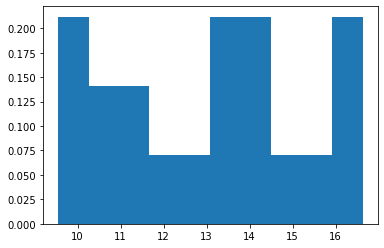

In [32]:
plt.hist(concrete_perf_raw["AMBP"], density=True)
plt.show()

### Sampled Performance

In [33]:
sampled_perf_agg

{'RMSE': 0.055, 'RMSE (std)': 0.01, 'AMBP': 3.001, 'AMBP (std)': 2.332}

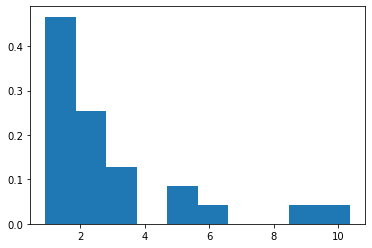

In [34]:
plt.hist(sampled_perf_raw["AMBP"], density=True)
plt.show()

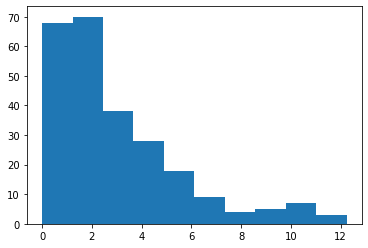

In [35]:
flat_list = [item for sublist in sampled_perf_run_raw["AMBP"] for item in sublist]
plt.hist(flat_list)
plt.show()

In [36]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

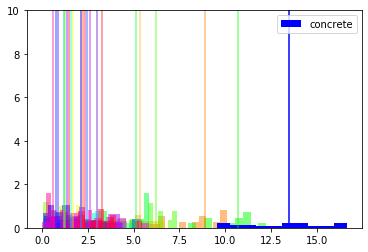

In [37]:
cmap = get_cmap(len(sampled_perf_run_raw["AMBP"]))

for i, runs in enumerate(sampled_perf_run_raw["AMBP"]):
    plt.hist(runs, density=True, alpha=0.5, color=cmap(i))
#     plt.axvline(x=np.mean(runs), alpha=0.25)
    plt.axvline(x=np.median(runs), alpha=0.5, c=cmap(i))
    
plt.hist(concrete_perf_raw["AMBP"], density=True, color="b", label="concrete")
# plt.axvline(x=np.mean(concrete_perf_raw["AMBP"]), c="r")
plt.axvline(x=np.median(concrete_perf_raw["AMBP"]), c="b")
plt.legend()
plt.ylim((0, 10))
plt.show()
# 

In [38]:
metric = "TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"

In [39]:
sample_metric_vals = sampled_data_raw[metric]
concrete_metric_val = concrete_data_agg[metric]

In [40]:
concrete_metric_val

0.787

In [41]:
np.abs(sample_metric_vals - concrete_metric_val), np.std(sample_metric_vals)

(array([0.067, 0.03 , 0.047, 0.221, 0.032, 0.064, 0.05 , 0.122, 0.213,
        0.206, 0.53 , 0.149, 0.196, 0.2  , 0.001, 0.047, 0.151, 0.169,
        0.125, 0.16 , 0.138, 0.054, 0.407, 0.098, 0.025]), 0.17061477544456694)

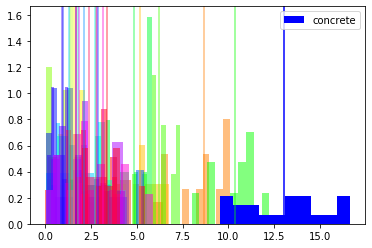

In [43]:
sample_metric_vals = sampled_data_raw[metric]
sample_metric_std = np.std(sample_metric_vals)
select_tol = 2*sample_metric_std
selected_runs = np.abs(sample_metric_vals - concrete_metric_val) < select_tol

cmap = get_cmap(len(sampled_perf_run_raw["AMBP"]))
for i, runs in enumerate(sampled_perf_run_raw["AMBP"]):
    if selected_runs[i]:
        plt.hist(runs, density=True, alpha=0.5, color=cmap(i))
        plt.axvline(x=np.mean(runs), alpha=0.5, c=cmap(i))
#         plt.axvline(x=np.median(runs), alpha=0.5, c=cmap(i))
        
    
plt.hist(concrete_perf_raw["AMBP"], density=True, color="b", label="concrete")
plt.axvline(x=np.mean(concrete_perf_raw["AMBP"]), c="b")
# plt.axvline(x=np.median(concrete_perf_raw["AMBP"]), c="b")
plt.legend()
plt.show()
# 

In [27]:
sampled_data_raw

defaultdict(list,
            {'OUTCOME_NONLINEARITY Lin r2(X_obs, Y)': [0.963,
              0.964,
              0.964,
              0.96,
              0.961,
              0.963,
              0.965,
              0.966,
              0.965,
              0.964,
              0.964,
              0.968,
              0.965,
              0.958,
              0.963,
              0.966,
              0.962,
              0.967,
              0.967,
              0.968,
              0.965,
              0.963,
              0.96,
              0.965,
              0.963],
             'OUTCOME_NONLINEARITY Lin r2(X_true, Y)': [0.964,
              0.966,
              0.965,
              0.963,
              0.963,
              0.964,
              0.967,
              0.968,
              0.968,
              0.968,
              0.968,
              0.969,
              0.967,
              0.961,
              0.965,
              0.967,
              0.963,
              0.96

### Exploratory Analysis

In [28]:
# data = np.array(sampled_perf_raw["absolute mean bias %"])
# clean_data = data[data < 20]
# plt.hist(clean_data)
# plt.show()
# np.mean(clean_data)

In [29]:
# plt.scatter(
#     np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
#     np.array(sampled_perf_raw["absolute mean bias %"])[data < 8])

In [30]:
# plt.scatter(
#     np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
#     np.array(sampled_perf_raw["absolute mean bias %"])[data < 8],
#     c="b")

# plt.scatter(
#     np.array(concrete_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"]),
#     np.array(concrete_perf_raw["absolute mean bias %"]),
#     c="r")